In [13]:
import pandas as pd
from sklearn import preprocessing
from itertools import groupby
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score

In [14]:
df = pd.read_csv('resources/matches_info.csv')

In [15]:
# convert gender to numeric
df['gender'] = df['gender'].map( {'female': 1, 'male': 0} ).astype(int)


In [16]:
# if outcome equals team1 then outcome = 1, else if outcome equals team2 then outcome = 2, else outcome = 1.5
df['outcome'] = df[['outcome', 'team1', 'team2']].apply( lambda x: -1 if x['outcome'] == x['team1'] else 1 if x['outcome'] == x['team2'] else 0, axis = 1 ).astype(float)

In [17]:
# convert toss decision to numeric
df['toss_decision'] = df['toss_decision'].map( {'bat': 1, 'field': 0} ).astype(int)

In [18]:
# if toss_winner equals team1 then outcome = 1, else if outcome equals team2 then outcome = 2, else outcome = 0
df['toss_winner'] = df[['toss_winner', 'team1', 'team2']].apply( lambda x: -1 if x['toss_winner'] == x['team1'] else 1 if x['toss_winner'] == x['team2'] else 0, axis = 1 ).astype(int)

In [19]:
city_encoder = preprocessing.LabelEncoder()
venue_encoder = preprocessing.LabelEncoder()
team_encoder = preprocessing.LabelEncoder()

In [20]:
df['city'].fillna('Unknown', inplace = True)

In [21]:
city_encoder = city_encoder.fit(df['city'])

In [22]:
df['city'] = city_encoder.transform(df['city'])

In [23]:
venue_encoder = venue_encoder.fit(df['venue'])
df['venue'] = venue_encoder.transform(df['venue'])

In [24]:
# unique values from team1 and team2 columns are used to create a new column called team
teams = df['team1'].append(df['team2']).unique()

C:\Users\HP\AppData\Local\Temp\ipykernel_12348\2291394802.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  teams = df['team1'].append(df['team2']).unique()


In [25]:
team_encoder = team_encoder.fit(teams)
df['team1'] = team_encoder.transform(df['team1'])
df['team2'] = team_encoder.transform(df['team2'])

In [26]:
# year is extracted from date column
df['year'] = df['date'].apply(lambda x: x.split('-')[0]).astype(int)

In [27]:
df['year'].value_counts(True)

2022    0.218656
2021    0.173727
2019    0.151904
2018    0.080873
2016    0.056483
2020    0.051776
2012    0.046213
2014    0.043218
2017    0.031237
2015    0.030809
2013    0.028669
2010    0.027813
2009    0.022251
2007    0.015404
2011    0.009842
2008    0.006418
2006    0.003423
2005    0.001284
Name: year, dtype: float64

<AxesSubplot:title={'center':'Year Value Counts'}>

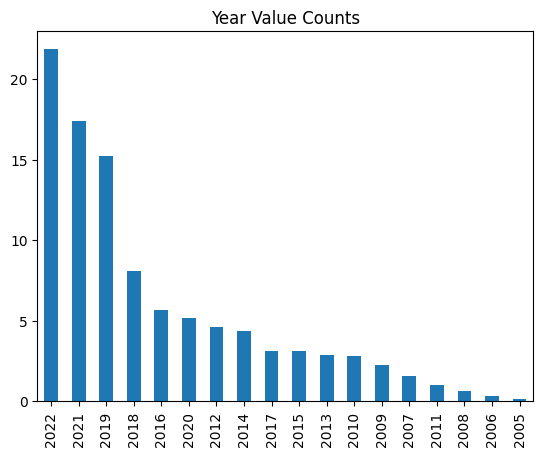

In [28]:
# plot the year value counts
(df['year'].value_counts(True) * 100).plot(kind='bar', title='Year Value Counts')

In [29]:
# find team win percentages
team_outcomes = df[['team2', 'outcome']]
team_outcomes = team_outcomes[team_outcomes['outcome'] > 0]
team_outcomes = team_outcomes.groupby(['team2'], as_index=False).sum().sort_values(by='outcome', ascending=False)
team_outcomes['team'] = team_encoder.inverse_transform(team_outcomes['team2'])

In [30]:
# total matches played by each team
team_matches = df[['team2', 'outcome']].groupby(['team2'], as_index=False).count().sort_values(by='team2', ascending=False)

In [31]:
# join team_outcomes and team_matches
team_outcomes = team_outcomes.merge(team_matches, left_on='team2', right_on='team2', how='inner')

In [32]:
team_outcomes['outcome_x'] = team_outcomes['outcome_x']/team_outcomes['outcome_y'] * 100

In [33]:
# drop team2 column
team_outcomes.drop('team2', axis=1, inplace=True)

# rename outcome column to win_percentage
team_outcomes.rename(columns={'outcome_x': 'win_percentage', 'outcome_y': 'matches_played'}, inplace=True)


,win_percentage,team,matches_played
3,54.576271,Pakistan,295
0,61.290323,India,279
1,61.231884,England,276
2,60.820896,Australia,268
4,54.000000,New Zealand,250
...,...,...,...
66,60.000000,Cook Islands,5
75,25.000000,ICC World XI,4
81,33.333333,Barbados,3
83,33.333333,Panama,3


In [34]:
team_outcomes.sort_values(by='matches_played', ascending=False).to_csv('resources/team_win_percentages.csv', index=False)

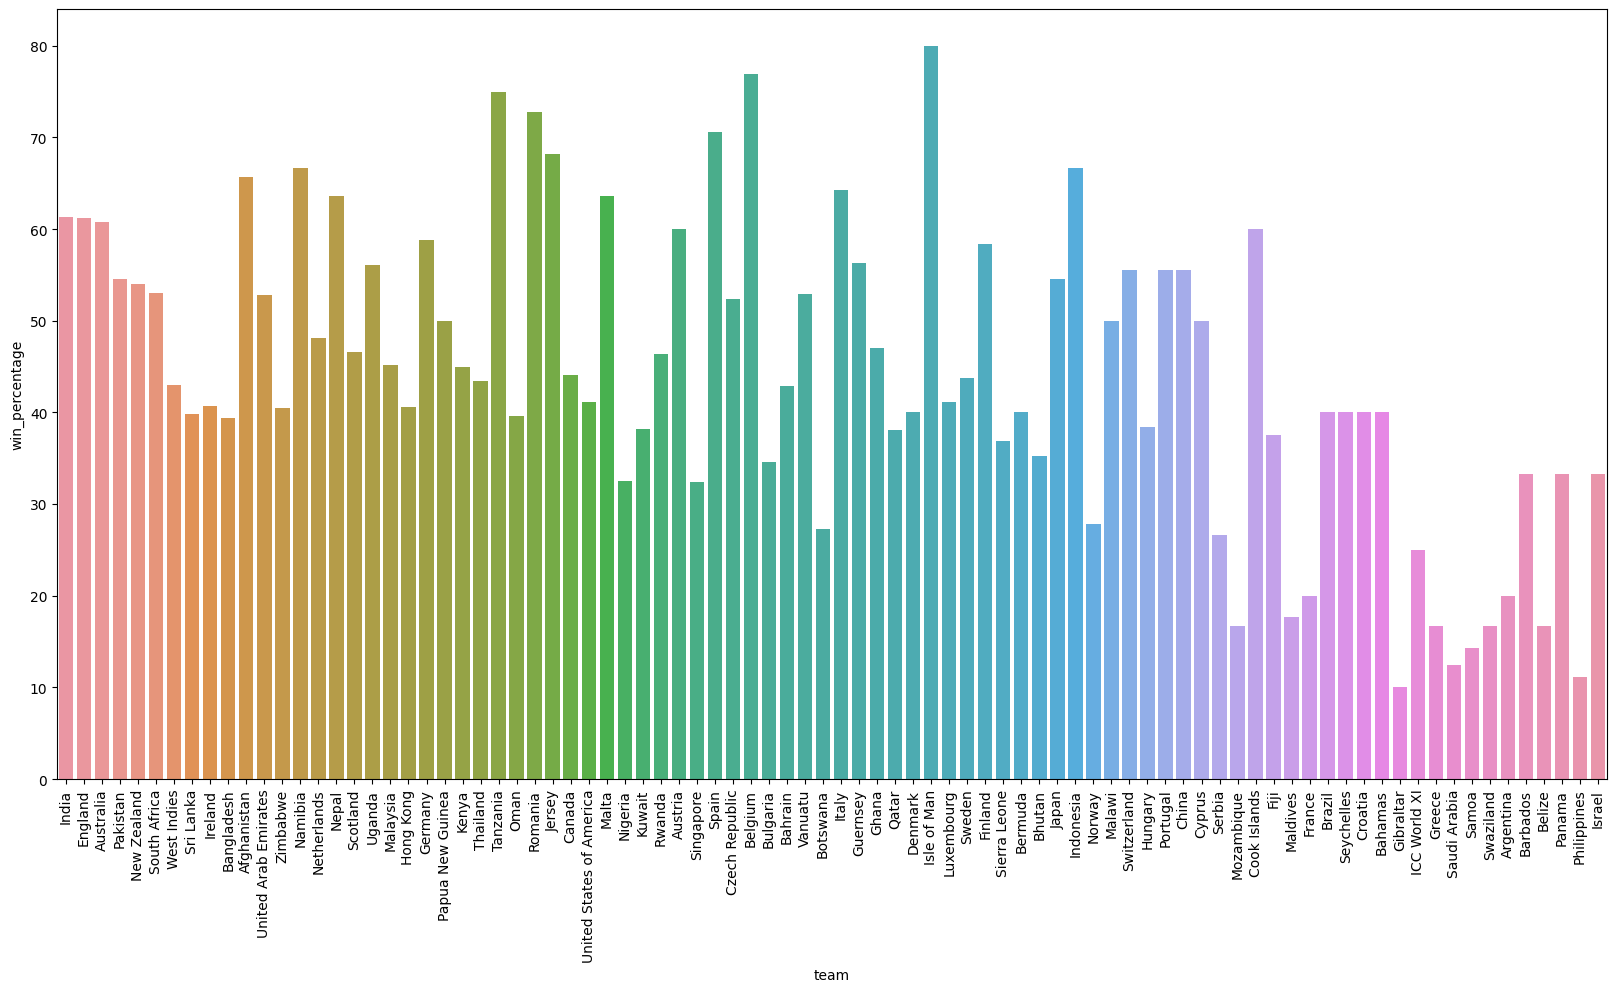

In [82]:
# plot win percentage of each team
plt.figure(figsize=(20,10))
sns.barplot(x='team', y='win_percentage', data=team_outcomes)
plt.xticks(rotation=90)
plt.show()

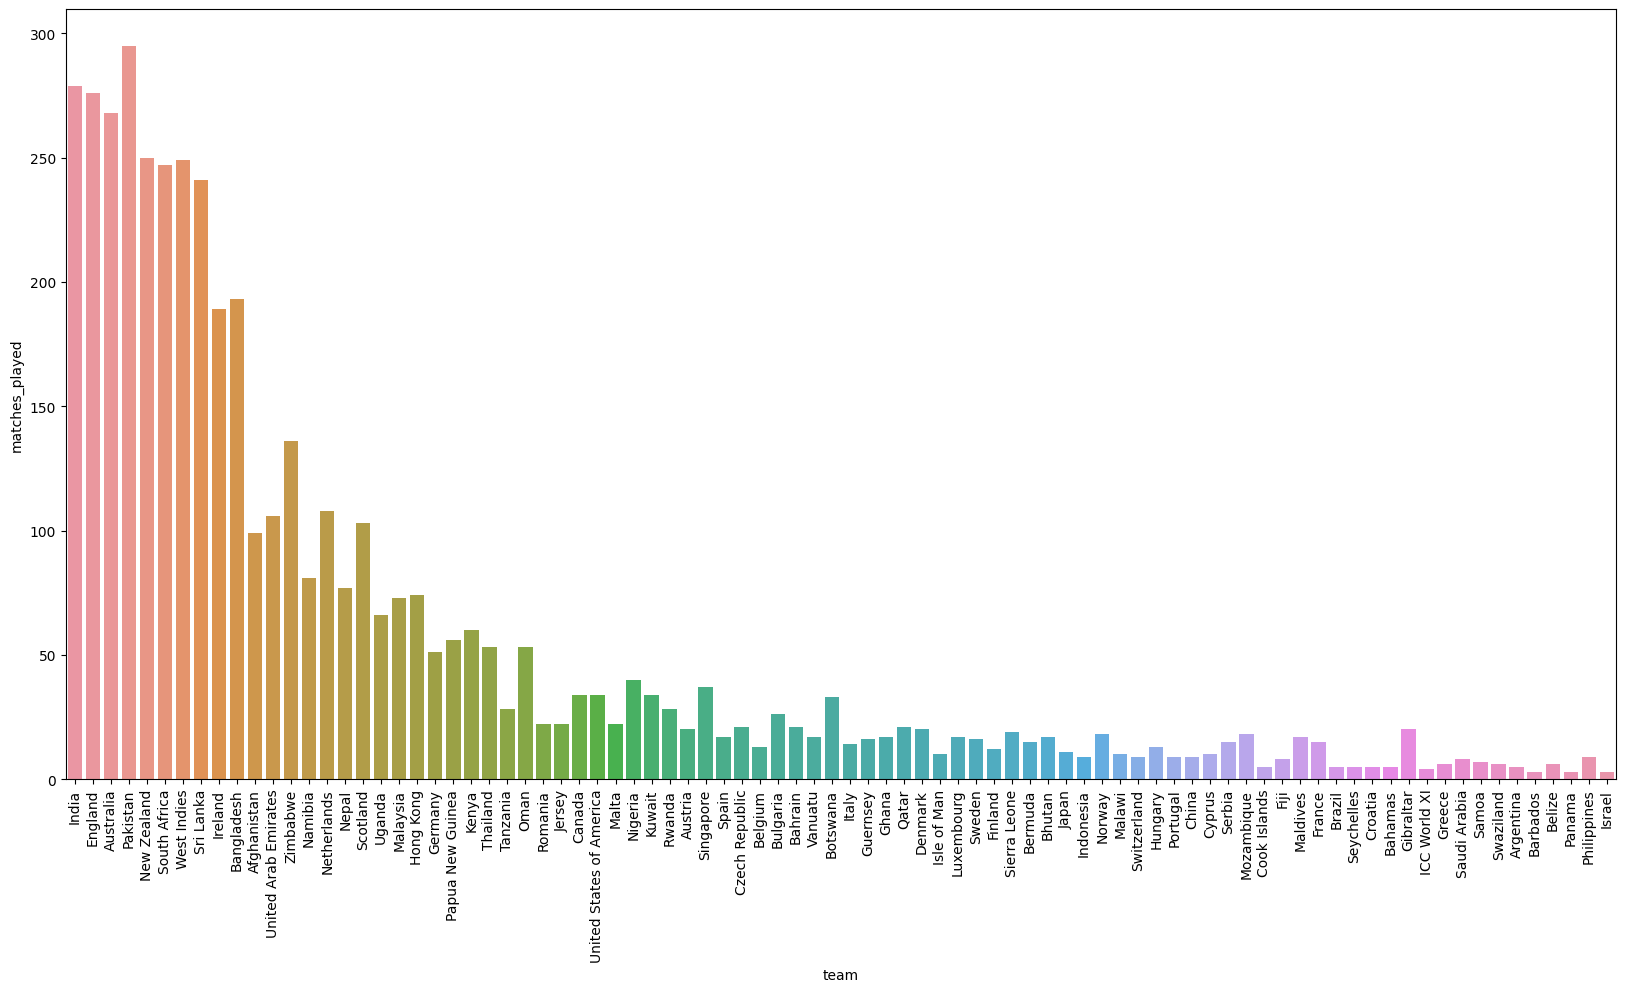

In [83]:
# plot matches played by each team
plt.figure(figsize=(20,10))
sns.barplot(x='team', y='matches_played', data=team_outcomes)
plt.xticks(rotation=90)
plt.show()


<AxesSubplot:xlabel='team'>

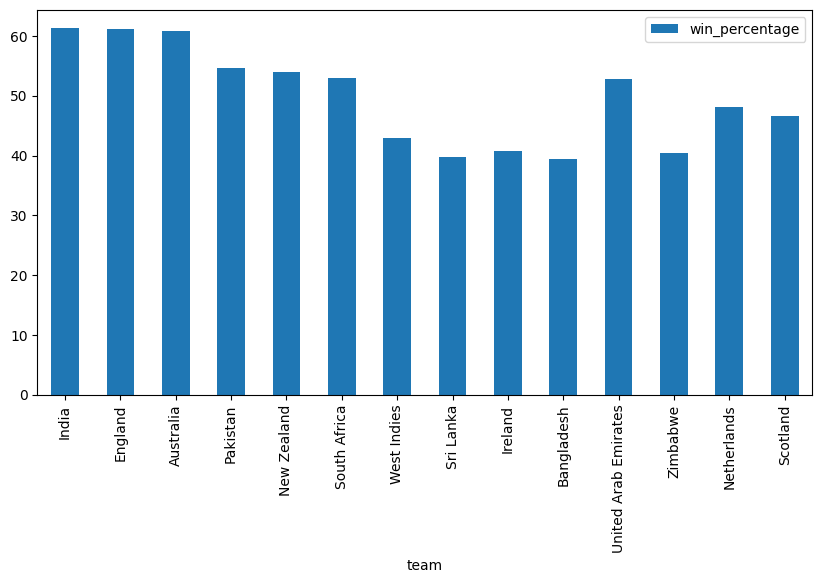

In [84]:
# plot win percentage of teams which have played atleast 100 matches
team_outcomes[team_outcomes['matches_played'] > 100].plot(x='team', y='win_percentage', kind='bar', figsize=(10, 5))

In [125]:
team_outcomes[team_outcomes['matches_played'] > 100]['team'].apply(lambda x: team_encoder.transform([x])[0]).values

array([38, 24,  2, 64, 60, 80, 94, 83, 41,  6, 91, 95, 59, 74])

In [85]:
#matches played per venue
venue_matches = df[['venue', 'outcome']].groupby(['venue'], as_index=False).count().sort_values(by='venue', ascending=False)
venue_matches['venue'] = venue_encoder.inverse_transform(venue_matches['venue'])
venue_matches.rename(columns={'outcome': 'matches_played'}, inplace=True)
venue_matches['matches_played'] = venue_matches['matches_played'].apply(lambda x: x/2)

In [86]:
venue_matches.sort_values(by='matches_played', ascending=False)

,venue,matches_played
71,Dubai International Cricket Stadium,86.0
2,Al Amerat Cricket Ground Oman Cricket (Ministr...,57.0
84,Gahanga International Cricket Stadium. Rwanda,55.0
226,Sheikh Zayed Stadium,44.0
228,Shere Bangla National Stadium,39.0
...,...,...
217,"Sawai Mansingh Stadium, Jaipur",1.0
31,Bready,1.0
93,"Greenfield International Stadium, Thiruvananth...",1.0
168,"National Cricket Stadium, St George's",1.0


In [87]:
#matches played per city
city_matches = df[['city', 'outcome']].groupby(['city'], as_index=False).count().sort_values(by='city', ascending=False)
city_matches['city'] = city_encoder.inverse_transform(city_matches['city'])
city_matches.rename(columns={'outcome': 'matches_played'}, inplace=True)
city_matches['matches_played'] = city_matches['matches_played'].apply(lambda x: x/2)

In [88]:
city_matches.sort_values(by='matches_played', ascending=False)

,city,matches_played
170,Unknown,191.0
58,Dubai,92.0
0,Abu Dhabi,87.0
4,Al Amarat,81.0
97,Kigali City,77.0
...,...,...
67,FTZ Sports Complex,1.0
61,Dunedin,1.0
55,Dharmasala,1.0
51,Derry,1.0


<AxesSubplot:xlabel='city'>

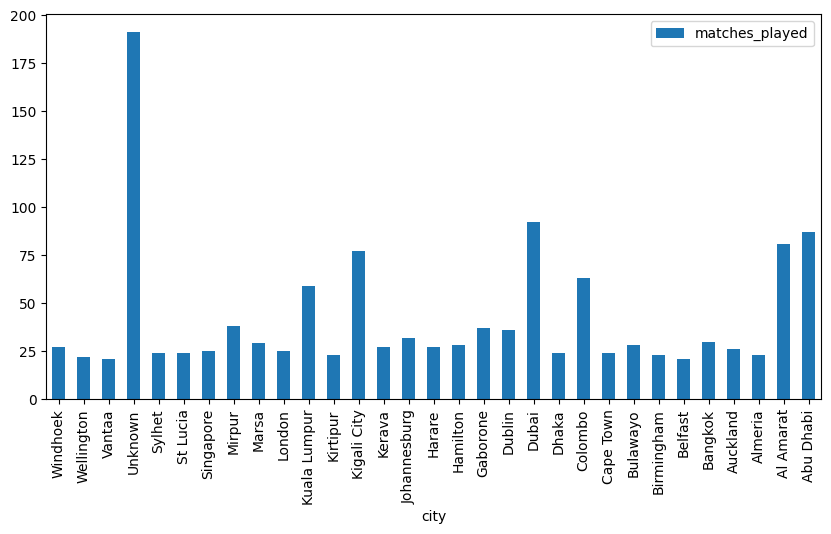

In [89]:
# plot matches played per city where atleast 20 matches have been played
city_matches[city_matches['matches_played'] > 20].plot(x='city', y='matches_played', kind='bar', figsize=(10, 5))

In [90]:
# replace unknown cities

df_unknown_city = df[df['city'] == 170]
venues_with_unknown_cities = df_unknown_city['venue'].unique()
df_venues_with_unknown_cities = df[df['venue'].isin(venues_with_unknown_cities)]

for index, value in df_venues_with_unknown_cities[['venue', 'city']].drop_duplicates().groupby('venue')['city'].apply(list).iteritems():
    # replace unknown city with city of venue
    df.loc[(df['city'] == 170) & (df['venue'] == index), 'city'] = next(filter(lambda x: x != 170, value), 170)

In [91]:
# unknown cities, need to be filled through google search
df_unknown_city = df[df['city'] == 170]
venues_with_unknown_cities = df_unknown_city['venue'].unique()
df_venues_with_unknown_cities = df[df['venue'].isin(venues_with_unknown_cities)]
df_venues_with_unknown_cities[['venue', 'city']].drop_duplicates().apply(lambda x: (x['venue'], venue_encoder.inverse_transform([x['venue']])[0]), axis=1)

530                 (52, Colombo Cricket Club Ground)
1472                (205, Rawalpindi Cricket Stadium)
1504              (162, Moara Vlasiei Cricket Ground)
3814                (85, Galle International Stadium)
3862                (164, Mombasa Sports Club Ground)
3894          (9, Arundel Castle Cricket Club Ground)
3960    (96, Guanggong International Cricket Stadium)
4116                            (257, Sylhet Stadium)
dtype: object

In [92]:
# add new feature to city encoder
city_encoder.classes_ = np.append(city_encoder.classes_, 'Rawalpindi')
city_encoder.classes_ = np.append(city_encoder.classes_, 'Moara')
city_encoder.classes_ = np.append(city_encoder.classes_, 'Galle')
city_encoder.classes_ = np.append(city_encoder.classes_, 'Mombasa')
city_encoder.classes_ = np.append(city_encoder.classes_, 'Arundel')
city_encoder.classes_ = np.append(city_encoder.classes_, 'Guanggong')

In [93]:
# replace unknown cities with thier encoding or with new encoding
df.loc[(df['city'] == 170) & (df['venue'] == 52), 'city'] = city_encoder.transform(["Colombo"])[0]
df.loc[(df['city'] == 170) & (df['venue'] == 206), 'city'] = city_encoder.transform(["Rawalpindi"])[0]
df.loc[(df['city'] == 170) & (df['venue'] == 163), 'city'] = city_encoder.transform(["Moara"])[0]
df.loc[(df['city'] == 170) & (df['venue'] == 85), 'city'] = city_encoder.transform(["Galle"])[0]
df.loc[(df['city'] == 170) & (df['venue'] == 165), 'city'] = city_encoder.transform(["Mombasa"])[0]
df.loc[(df['city'] == 170) & (df['venue'] == 9), 'city'] = city_encoder.transform(["Arundel"])[0]
df.loc[(df['city'] == 170) & (df['venue'] == 96), 'city'] = city_encoder.transform(["Guanggong"])[0]
df.loc[(df['city'] == 170) & (df['venue'] == 258), 'city'] = city_encoder.transform(["Sylhet"])[0]

In [94]:

len(team_encoder.classes_)

96

<AxesSubplot:xlabel='city'>

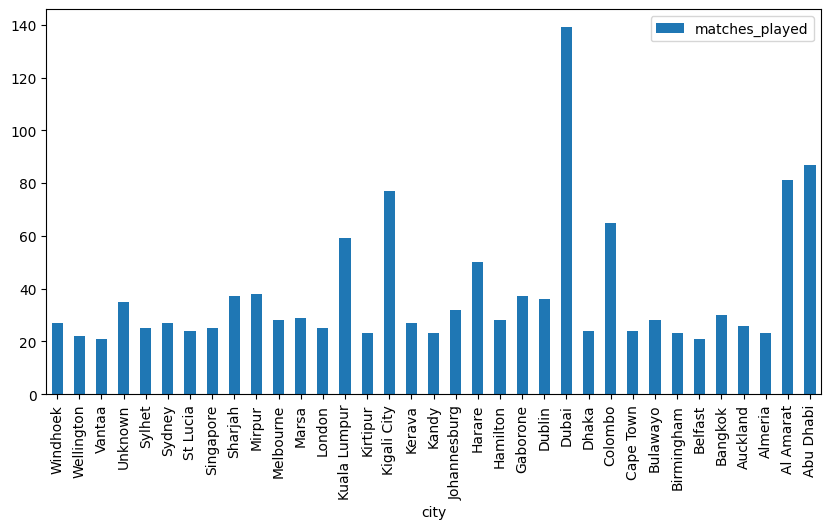

In [95]:
# check matches played per city after filling unknown cities
city_matches = df[['city', 'outcome']].groupby(['city'], as_index=False).count().sort_values(by='city', ascending=False)
city_matches['city'] = city_encoder.inverse_transform(city_matches['city'])
city_matches.rename(columns={'outcome': 'matches_played'}, inplace=True)
city_matches['matches_played'] = city_matches['matches_played'].apply(lambda x: x/2)

# plot matches played per city where atleast 20 matches have been played
city_matches[city_matches['matches_played'] > 20].plot(x='city', y='matches_played', kind='bar', figsize=(10, 5))

In [96]:
# replace -1 with mean of column
df.loc[df['team1_batting_average'] == -1, 'team1_batting_average'] = df[df['team1_batting_average'] != -1]['team1_batting_average'].values.mean()
df.loc[df['team2_batting_average'] == -1, 'team2_batting_average'] = df[df['team2_batting_average'] != -1]['team2_batting_average'].values.mean()
df.loc[df['team1_bowling_average'] == -1, 'team1_bowling_average'] = df[df['team1_bowling_average'] != -1]['team1_bowling_average'].values.mean()
df.loc[df['team2_bowling_average'] == -1, 'team2_bowling_average'] = df[df['team2_bowling_average'] != -1]['team2_bowling_average'].values.mean()
df.loc[df['team1_batting_strike_rate'] == -1, 'team1_batting_strike_rate'] = df[df['team1_batting_strike_rate'] != -1]['team1_batting_strike_rate'].values.mean()
df.loc[df['team2_batting_strike_rate'] == -1, 'team2_batting_strike_rate'] = df[df['team2_batting_strike_rate'] != -1]['team2_batting_strike_rate'].values.mean()
df.loc[df['team1_bowling_strike_rate'] == -1, 'team1_bowling_strike_rate'] = df[df['team1_bowling_strike_rate'] != -1]['team1_bowling_strike_rate'].values.mean()
df.loc[df['team2_bowling_strike_rate'] == -1, 'team2_bowling_strike_rate'] = df[df['team2_bowling_strike_rate'] != -1]['team2_bowling_strike_rate'].values.mean()
df.loc[df['team1_bowling_economy'] == -1, 'team1_bowling_economy'] = df[df['team1_bowling_economy'] != -1]['team1_bowling_economy'].values.mean()
df.loc[df['team2_bowling_economy'] == -1, 'team2_bowling_economy'] = df[df['team2_bowling_economy'] != -1]['team2_bowling_economy'].values.mean()
df.loc[df['team1_bowling_maidens_normalized'] == -1, 'team1_bowling_maidens_normalized'] = df[df['team1_bowling_maidens_normalized'] != -1]['team1_bowling_maidens_normalized'].values.mean()
df.loc[df['team2_bowling_maidens_normalized'] == -1, 'team2_bowling_maidens_normalized'] = df[df['team2_bowling_maidens_normalized'] != -1]['team2_bowling_maidens_normalized'].values.mean()
df.loc[df['team1_batting_100s_normalized'] == -1, 'team1_batting_100s_normalized'] = df[df['team1_batting_100s_normalized'] != -1]['team1_batting_100s_normalized'].values.mean()
df.loc[df['team2_batting_100s_normalized'] == -1, 'team2_batting_100s_normalized'] = df[df['team2_batting_100s_normalized'] != -1]['team2_batting_100s_normalized'].values.mean()
df.loc[df['team1_batting_50s_normalized'] == -1, 'team1_batting_50s_normalized'] = df[df['team1_batting_50s_normalized'] != -1]['team1_batting_50s_normalized'].values.mean()
df.loc[df['team2_batting_50s_normalized'] == -1, 'team2_batting_50s_normalized'] = df[df['team2_batting_50s_normalized'] != -1]['team2_batting_50s_normalized'].values.mean()
df.loc[df['team1_batting_4s_normalized'] == -1, 'team1_batting_4s_normalized'] = df[df['team1_batting_4s_normalized'] != -1]['team1_batting_4s_normalized'].values.mean()
df.loc[df['team2_batting_4s_normalized'] == -1, 'team2_batting_4s_normalized'] = df[df['team2_batting_4s_normalized'] != -1]['team2_batting_4s_normalized'].values.mean()
df.loc[df['team1_batting_6s_normalized'] == -1, 'team1_batting_6s_normalized'] = df[df['team1_batting_6s_normalized'] != -1]['team1_batting_6s_normalized'].values.mean()
df.loc[df['team2_batting_6s_normalized'] == -1, 'team2_batting_6s_normalized'] = df[df['team2_batting_6s_normalized'] != -1]['team2_batting_6s_normalized'].values.mean()

In [97]:
# difference in all features between team 1 and team 2
df['batting_average_difference'] = df['team2_batting_average'] - df['team1_batting_average']
df['bowling_average_difference'] = df['team2_bowling_average'] - df['team1_bowling_average']
df['batting_strike_rate_difference'] = df['team2_batting_strike_rate'] - df['team1_batting_strike_rate']
df['bowling_strike_rate_difference'] = df['team2_bowling_strike_rate'] - df['team1_bowling_strike_rate']
df['bowling_economy_difference'] = df['team2_bowling_economy'] - df['team1_bowling_economy']
df['bowling_maidens_normalized_difference'] = df['team2_bowling_maidens_normalized'] - df['team1_bowling_maidens_normalized']
df['batting_100s_normalized_difference'] = df['team2_batting_100s_normalized'] - df['team1_batting_100s_normalized']
df['batting_50s_normalized_difference'] = df['team2_batting_50s_normalized'] - df['team1_batting_50s_normalized']
df['batting_4s_normalized_difference'] = df['team2_batting_4s_normalized'] - df['team1_batting_4s_normalized']
df['batting_6s_normalized_difference'] = df['team2_batting_6s_normalized'] - df['team1_batting_6s_normalized']

array([[<AxesSubplot:title={'center':'team1_batting_average'}>,
        <AxesSubplot:title={'center':'team1_bowling_average'}>,
        <AxesSubplot:title={'center':'team1_batting_strike_rate'}>],
       [<AxesSubplot:title={'center':'team1_bowling_strike_rate'}>,
        <AxesSubplot:title={'center':'team1_bowling_economy'}>,
        <AxesSubplot:title={'center':'team1_bowling_maidens_normalized'}>],
       [<AxesSubplot:title={'center':'team1_batting_100s_normalized'}>,
        <AxesSubplot:title={'center':'team1_batting_50s_normalized'}>,
        <AxesSubplot:title={'center':'team1_batting_4s_normalized'}>],
       [<AxesSubplot:title={'center':'team1_batting_6s_normalized'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

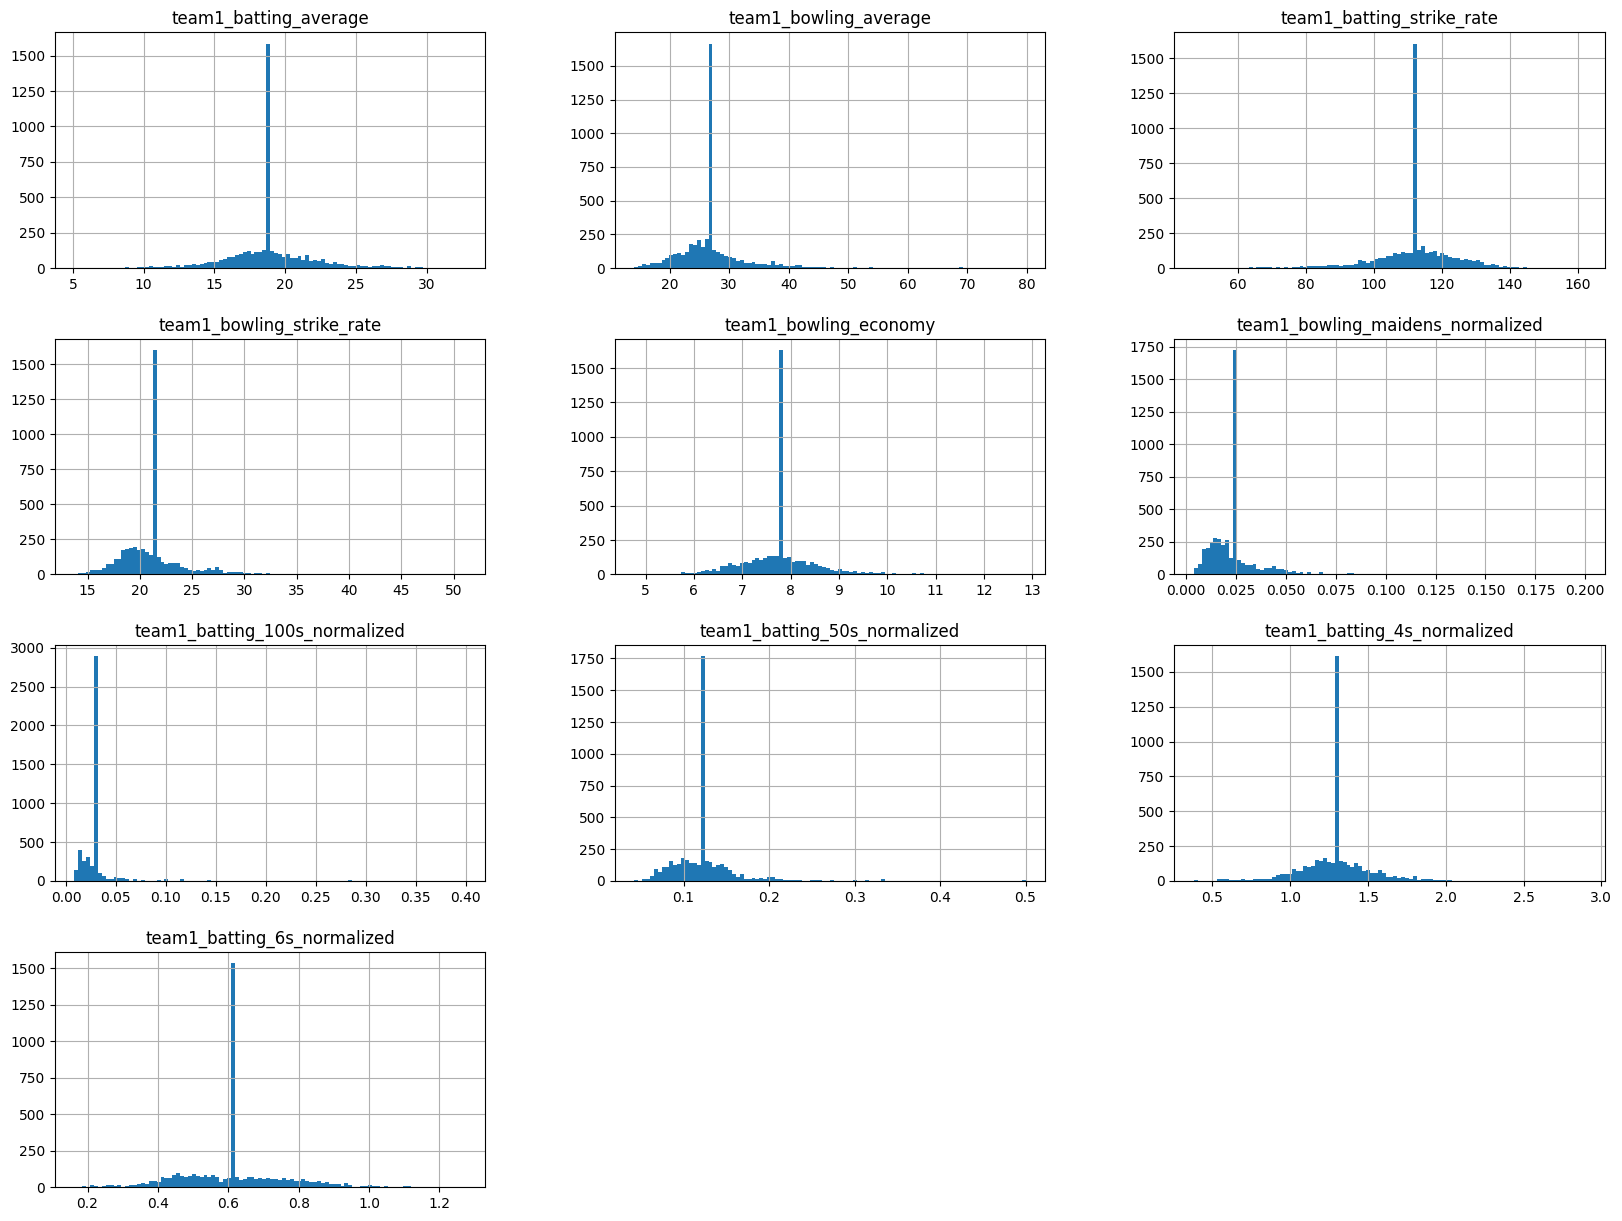

In [98]:
#plot multiple histograms of only team 1 features
df[['team1_batting_average', 'team1_bowling_average', 'team1_batting_strike_rate', 'team1_bowling_strike_rate', 'team1_bowling_economy', 'team1_bowling_maidens_normalized', 'team1_batting_100s_normalized', 'team1_batting_50s_normalized', 'team1_batting_4s_normalized', 'team1_batting_6s_normalized']].hist(bins=100, figsize=(20,15))

In [99]:
# save cleaned data
df.to_csv('cleaned_data.csv', index=False)

In [66]:
df = pd.read_csv('cleaned_data.csv')
player_df = pd.read_csv('resources/player_career_averages.csv')

In [167]:
player_df.head()

,id,batting_average,batting_strike_rate,batting_100s_normalized,batting_50s_normalized,batting_6s_normalized,batting_4s_normalized,batting_highest_score,batting_not_outs_normalized,bowling_average,bowling_strike_rate,bowling_economy,bowling_maidens_normalized,identifier
0,1163136,9.83,79.72,0.0,0.000000,0.500000,0.833333,28.0,0.000000,0.00,0.0,0.00,0.000000,fd3c5c00
1,590021,9.28,100.00,0.0,0.000000,0.428571,1.000000,28.0,0.000000,56.00,60.0,5.60,0.000000,02d11602
2,1269467,16.08,126.14,0.0,0.058824,0.470588,0.941176,0.0,0.294118,0.00,0.0,0.00,0.000000,9dbc77b3
3,1323426,0.00,60.00,0.0,0.000000,0.000000,0.000000,0.0,1.000000,10.36,9.9,6.27,0.110497,a768a762
4,1203910,5.16,70.45,0.0,0.000000,0.000000,0.428571,15.0,0.142857,25.83,17.6,8.77,0.000000,55a5cffb


In [168]:
# normalize data by subtracting mean and dividing by standard deviation
df['team1_batting_average'] = (df['team1_batting_average'] - player_df['batting_average'].mean()) / player_df['batting_average'].std()
df['team2_batting_average'] = (df['team2_batting_average'] - player_df['batting_average'].mean()) / player_df['batting_average'].std()
df['team1_bowling_average'] = (df['team1_bowling_average'] - player_df['bowling_average'].mean()) / player_df['bowling_average'].std()
df['team2_bowling_average'] = (df['team2_bowling_average'] - player_df['bowling_average'].mean()) / player_df['bowling_average'].std()
df['team1_batting_strike_rate'] = (df['team1_batting_strike_rate'] - player_df['batting_strike_rate'].mean()) / player_df['batting_strike_rate'].std()
df['team2_batting_strike_rate'] = (df['team2_batting_strike_rate'] - player_df['batting_strike_rate'].mean()) / player_df['batting_strike_rate'].std()
df['team1_bowling_strike_rate'] = (df['team1_bowling_strike_rate'] - player_df['bowling_strike_rate'].mean()) / player_df['bowling_strike_rate'].std()
df['team2_bowling_strike_rate'] = (df['team2_bowling_strike_rate'] - player_df['bowling_strike_rate'].mean()) / player_df['bowling_strike_rate'].std()
df['team1_bowling_economy'] = (df['team1_bowling_economy'] - player_df['bowling_economy'].mean()) / player_df['bowling_economy'].std()
df['team2_bowling_economy'] = (df['team2_bowling_economy'] - player_df['bowling_economy'].mean()) / player_df['bowling_economy'].std()
df['team1_bowling_maidens_normalized'] = (df['team1_bowling_maidens_normalized'] - player_df['bowling_maidens_normalized'].mean()) / player_df['bowling_maidens_normalized'].std()
df['team2_bowling_maidens_normalized'] = (df['team2_bowling_maidens_normalized'] - player_df['bowling_maidens_normalized'].mean()) / player_df['bowling_maidens_normalized'].std()
df['team1_batting_100s_normalized'] = (df['team1_batting_100s_normalized'] - player_df['batting_100s_normalized'].mean()) / player_df['batting_100s_normalized'].std()
df['team2_batting_100s_normalized'] = (df['team2_batting_100s_normalized'] - player_df['batting_100s_normalized'].mean()) / player_df['batting_100s_normalized'].std()
df['team1_batting_50s_normalized'] = (df['team1_batting_50s_normalized'] - player_df['batting_50s_normalized'].mean()) / player_df['batting_50s_normalized'].std()
df['team2_batting_50s_normalized'] = (df['team2_batting_50s_normalized'] - player_df['batting_50s_normalized'].mean()) / player_df['batting_50s_normalized'].std()
df['team1_batting_4s_normalized'] = (df['team1_batting_4s_normalized'] - player_df['batting_4s_normalized'].mean()) / player_df['batting_4s_normalized'].std()
df['team2_batting_4s_normalized'] = (df['team2_batting_4s_normalized'] - player_df['batting_4s_normalized'].mean()) / player_df['batting_4s_normalized'].std()
df['team1_batting_6s_normalized'] = (df['team1_batting_6s_normalized'] - player_df['batting_6s_normalized'].mean()) / player_df['batting_6s_normalized'].std()
df['team2_batting_6s_normalized'] = (df['team2_batting_6s_normalized'] - player_df['batting_6s_normalized'].mean()) / player_df['batting_6s_normalized'].std()

In [67]:
# difference in all features between team 1 and team 2
df['batting_average_difference'] = df['team2_batting_average'] - df['team1_batting_average']
df['bowling_average_difference'] = df['team2_bowling_average'] - df['team1_bowling_average']
df['batting_strike_rate_difference'] = df['team2_batting_strike_rate'] - df['team1_batting_strike_rate']
df['bowling_strike_rate_difference'] = df['team2_bowling_strike_rate'] - df['team1_bowling_strike_rate']
df['bowling_economy_difference'] = df['team2_bowling_economy'] - df['team1_bowling_economy']
df['bowling_maidens_normalized_difference'] = df['team2_bowling_maidens_normalized'] - df['team1_bowling_maidens_normalized']
df['batting_100s_normalized_difference'] = df['team2_batting_100s_normalized'] - df['team1_batting_100s_normalized']
df['batting_50s_normalized_difference'] = df['team2_batting_50s_normalized'] - df['team1_batting_50s_normalized']
df['batting_4s_normalized_difference'] = df['team2_batting_4s_normalized'] - df['team1_batting_4s_normalized']
df['batting_6s_normalized_difference'] = df['team2_batting_6s_normalized'] - df['team1_batting_6s_normalized']

In [170]:
df.to_csv('normalized_cleaned_data.csv', index=False)

In [62]:
df = pd.read_csv('normalized_cleaned_data.csv')

In [37]:
df.drop_duplicates(subset='id', keep='first', inplace=True)

In [68]:
# drop unnecessary columns
df = df.drop(['date', 'match_type', 'team_type'], axis=1)

In [69]:
# correlation matrix of all features with target variable outcome 
corr = df.corr()

In [70]:
features = corr['outcome'].sort_values(ascending=False).round(3)

In [93]:
features

outcome                                  1.000
batting_strike_rate_difference           0.311
batting_average_difference               0.307
batting_4s_normalized_difference         0.251
team2_batting_average                    0.194
team2_batting_strike_rate                0.183
team2_batting_4s_normalized              0.161
batting_6s_normalized_difference         0.159
team1_bowling_average                    0.109
team2_batting_6s_normalized              0.104
team1_bowling_strike_rate                0.098
team1_bowling_economy                    0.088
batting_50s_normalized_difference        0.074
team2_batting_50s_normalized             0.047
team1                                    0.044
team1_bowling_maidens_normalized         0.004
batting_100s_normalized_difference       0.000
team2_batting_100s_normalized            0.000
toss_winner                              0.000
venue                                    0.000
city                                    -0.000
gender       

In [71]:
# get features with absolute correlation greater than 0.1
relevant_features = features[abs(features) > 0.01].index.tolist()

# remove outcome from list
relevant_features.remove('outcome')

# add id to start of list
relevant_features.insert(0, 'id')

In [113]:
# # remove following features from relevant features list
# remove_features = ['team2_batting_average', 'team1_batting_average', 'team2_bowling_average', 'team1_bowling_average', 'team2_batting_strike_rate', 'team1_batting_strike_rate', 'team2_bowling_strike_rate', 'team1_bowling_strike_rate', 'team2_bowling_economy', 'team1_bowling_economy', 'team2_bowling_maidens_normalized', 'team1_bowling_maidens_normalized', 'team2_batting_100s_normalized', 'team1_batting_100s_normalized', 'team2_batting_50s_normalized', 'team1_batting_50s_normalized', 'team2_batting_4s_normalized', 'team1_batting_4s_normalized', 'team2_batting_6s_normalized', 'team1_batting_6s_normalized']

# for feature in remove_features:
#     try:
#         relevant_features.remove(feature)
#     except:
#         pass

In [72]:
# split data into training and test sets
X = df.drop(['outcome'], axis=1)
Y = df['outcome']

In [73]:
# drop all irrelevant features
X = X[relevant_features]

In [74]:
# drop target variable from features
X = X.drop(['target'], axis=1)

KeyError: "['target'] not found in axis"

In [12]:
X.to_csv('LSTM/matches_info.csv', index=False)

In [75]:
# drop id variable from features
X = X.drop(['id'], axis=1)

In [47]:
X.head()

,batting_strike_rate_difference,batting_average_difference,batting_4s_normalized_difference,team2_batting_average,team2_batting_strike_rate,team2_batting_4s_normalized,batting_6s_normalized_difference,team1_bowling_strike_rate,team1_bowling_average,team2_batting_6s_normalized,team1_batting_4s_normalized,bowling_strike_rate_difference,bowling_economy_difference,bowling_average_difference,team1_batting_average,team1_batting_strike_rate
0,0.080769,-0.294955,-0.063082,0.171511,0.555720,0.284363,-0.101667,0.492111,0.508110,0.326563,0.347445,0.469497,-0.103424,0.504606,0.466466,0.474952
2,0.073515,-0.334219,0.015492,0.288132,0.688357,0.417970,-0.059799,0.552626,0.604754,0.433875,0.402478,0.474036,-0.139471,0.496195,0.622351,0.614842
4,0.099553,-0.284239,-0.085190,0.302915,0.663977,0.310703,-0.024151,0.599021,0.612709,0.530428,0.395893,0.342289,-0.090678,0.398665,0.587154,0.564425
6,0.049840,0.199742,-0.337234,0.255492,0.248441,0.113413,0.225425,0.311372,0.250405,0.468994,0.450647,0.436668,-0.116232,0.431974,0.055751,0.198601
8,-0.230559,0.547490,0.582535,0.955528,0.254803,0.887263,-0.005862,0.790204,0.906967,0.692772,0.304727,-0.361634,-0.033411,-0.400415,0.408038,0.485363


In [76]:
# Logistic Regression

logreg = LogisticRegression( solver='lbfgs', max_iter=1000)
logreg_cv_scores = cross_val_score(logreg, X, Y, cv=5)
print("Logistic Regression Accuracy: %0.2f (+/- %0.2f)" % (logreg_cv_scores.mean() * 100, logreg_cv_scores.std() * 100))

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Logistic Regression Accuracy: 62.52 (+/- 1.70)


C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [77]:
# Support Vector Machines

svc = SVC()
svc_cv_scores = cross_val_score(svc, X, Y, cv=5)
print("Support Vector Machines Accuracy: %0.2f (+/- %0.2f)" % (svc_cv_scores.mean() * 100, svc_cv_scores.std() * 100))

Support Vector Machines Accuracy: 61.87 (+/- 2.12)


In [78]:
# KNN

knn = KNeighborsClassifier(n_neighbors = 45)
knn_cv_scores = cross_val_score(knn, X, Y, cv=5)
print("KNN Accuracy: %0.2f (+/- %0.2f)" % (knn_cv_scores.mean() * 100, knn_cv_scores.std() * 100))

KNN Accuracy: 59.78 (+/- 1.58)


In [79]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian_cv_scores = cross_val_score(gaussian, X, Y, cv=5)
print("Gaussian Naive Bayes Accuracy: %0.2f (+/- %0.2f)" % (gaussian_cv_scores.mean() * 100, gaussian_cv_scores.std() * 100))

Gaussian Naive Bayes Accuracy: 50.00 (+/- 11.07)


In [80]:
# Perceptron

perceptron = Perceptron()
perceptron_cv_scores = cross_val_score(perceptron, X, Y, cv=5)
print("Perceptron Accuracy: %0.2f (+/- %0.2f)" % (perceptron_cv_scores.mean() * 100, perceptron_cv_scores.std() * 100))

Perceptron Accuracy: 57.89 (+/- 3.37)


In [81]:
# Linear SVC

linear_svc = LinearSVC(max_iter=1000)
linear_svc_cv_scores = cross_val_score(linear_svc, X, Y, cv=5)
print("Linear SVC Accuracy: %0.2f (+/- %0.2f)" % (linear_svc_cv_scores.mean() * 100, linear_svc_cv_scores.std() * 100))

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVC Accuracy: 55.91 (+/- 4.68)


C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [82]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd_cv_scores = cross_val_score(sgd, X, Y, cv=5)
print("Stochastic Gradient Descent Accuracy: %0.2f (+/- %0.2f)" % (sgd_cv_scores.mean() * 100, sgd_cv_scores.std() * 100))

Stochastic Gradient Descent Accuracy: 46.56 (+/- 19.73)


In [83]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree_cv_scores = cross_val_score(decision_tree, X, Y, cv=5)
print("Decision Tree Accuracy: %0.2f (+/- %0.2f)" % (decision_tree_cv_scores.mean() * 100, decision_tree_cv_scores.std() * 100))

Decision Tree Accuracy: 60.63 (+/- 3.36)


In [84]:
X

,batting_strike_rate_difference,batting_average_difference,batting_4s_normalized_difference,team2_batting_average,team2_batting_strike_rate,team2_batting_4s_normalized,batting_6s_normalized_difference,team1_bowling_average,team2_batting_6s_normalized,team1_bowling_strike_rate,...,team2_bowling_economy,team2_bowling_strike_rate,team1_batting_6s_normalized,team2_bowling_average,bowling_strike_rate_difference,bowling_economy_difference,team1_batting_4s_normalized,bowling_average_difference,team1_batting_strike_rate,team1_batting_average
0,3.897273,-3.428182,-0.058056,14.890909,115.360909,1.093144,-0.044926,26.422500,0.461962,19.800000,...,8.042500,26.450000,0.506888,36.300000,6.650000,-0.451944,1.151200,9.877500,111.463636,18.319091
1,-3.897273,3.428182,0.058056,18.319091,111.463636,1.151200,0.044926,36.300000,0.506888,26.450000,...,8.494444,19.800000,0.461962,26.422500,-6.650000,0.451944,1.093144,-9.877500,115.360909,14.890909
2,3.547273,-3.884545,0.014257,16.246364,121.760909,1.216106,-0.026425,28.314286,0.509383,20.657143,...,8.154286,27.371429,0.535807,38.027143,6.714286,-0.609464,1.201849,9.712857,118.213636,20.130909
3,-3.547273,3.884545,-0.014257,20.130909,118.213636,1.201849,0.026425,38.027143,0.535807,27.371429,...,8.763750,20.657143,0.509383,28.314286,-6.714286,0.609464,1.216106,-9.712857,121.760909,16.246364
4,4.803636,-3.303636,-0.078403,16.418182,120.584545,1.117386,-0.010672,28.470000,0.552049,21.314286,...,8.147500,26.162500,0.562722,36.273750,4.848214,-0.396250,1.195788,7.803750,115.780909,19.721818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4669,-18.534343,-4.661818,-0.280326,13.880000,93.441111,1.026410,0.097844,24.807000,0.502027,20.080000,...,7.462857,21.033333,0.404183,25.535000,0.953333,0.081857,1.306737,0.728000,111.975455,18.541818
4670,28.593182,4.454545,-0.060304,21.500000,134.515000,1.303964,0.083818,30.598571,0.640282,22.742857,...,7.991429,21.742857,0.556464,29.522857,-1.000000,-0.065714,1.364268,-1.075714,105.921818,17.045455
4671,-28.593182,-4.454545,0.060304,17.045455,105.921818,1.364268,-0.083818,29.522857,0.556464,21.742857,...,8.057143,22.742857,0.640282,30.598571,1.000000,0.065714,1.303964,1.075714,134.515000,21.500000
4672,18.482727,2.904545,-0.067250,20.611818,133.181818,1.232084,0.018232,31.191429,0.585089,24.100000,...,7.960000,22.385714,0.566857,30.277143,-1.714286,0.204286,1.299334,-0.914286,114.699091,17.707273


In [91]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=1000)
random_forest_cv_scores = cross_val_score(random_forest, X, Y, cv=5)
print("Random Forest Accuracy: %0.2f (+/- %0.2f)" % (random_forest_cv_scores.mean() * 100, random_forest_cv_scores.std() * 100))

Random Forest Accuracy: 67.74 (+/- 4.15)


In [86]:
# modify train and test sets outcome column to 0 and 1
Y_modified = Y.replace([-1, 0, 1], [0, 1, 2])

# XGBoost
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_cv_scores = cross_val_score(xgb_model, X, Y_modified, cv=5)
print("XGBoost Accuracy: %0.2f (+/- %0.2f)" % (xgb_cv_scores.mean() * 100, xgb_cv_scores.std() * 100))

XGBoost Accuracy: 65.17 (+/- 3.21)


In [87]:
# MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=1000) 
mlp_cv_scores = cross_val_score(mlp, X, Y, cv=5)
print("MLP Classifier Accuracy: %0.2f (+/- %0.2f)" % (mlp_cv_scores.mean() * 100, mlp_cv_scores.std() * 100))

MLP Classifier Accuracy: 60.23 (+/- 1.87)


In [88]:
# lightgbm
lgbm = lgb.LGBMClassifier()
lgbm_cv_scores = cross_val_score(lgbm, X, Y_modified, cv=5)
print("LightGBM Accuracy: %0.2f (+/- %0.2f)" % (lgbm_cv_scores.mean() * 100, lgbm_cv_scores.std() * 100))

LightGBM Accuracy: 63.59 (+/- 3.54)


In [89]:
# catboost
cat = cb.CatBoostClassifier(verbose=0)
cat_cv_scores = cross_val_score(cat, X, Y_modified, cv=5)
print("CatBoost Accuracy: %0.2f (+/- %0.2f)" % (cat_cv_scores.mean() * 100, cat_cv_scores.std() * 100))

CatBoost Accuracy: 63.91 (+/- 3.11)


In [92]:
# result for features with correlation greater than 0.01
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',

                'Random Forest', 'Naive Bayes', 'Perceptron',

                'Stochastic Gradient Decent', 'Linear SVC',

                'Decision Tree', 'XGBoost', 'MLP Classifier', 'LightGBM', 'CatBoost'],
    'Training Accuracy': [svc_cv_scores.mean() * 100, knn_cv_scores.mean() * 100, logreg_cv_scores.mean() * 100,


                random_forest_cv_scores.mean() * 100, gaussian_cv_scores.mean() * 100, perceptron_cv_scores.mean() * 100,

                sgd_cv_scores.mean() * 100, linear_svc_cv_scores.mean() * 100,

                decision_tree_cv_scores.mean() * 100, xgb_cv_scores.mean() * 100, mlp_cv_scores.mean() * 100, lgbm_cv_scores.mean() * 100, cat_cv_scores.mean() * 100]})
result_df = results.sort_values(by='Training Accuracy', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Training Accuracy
Model,
Random Forest,67.735781
XGBoost,65.168272
CatBoost,63.906240
LightGBM,63.585247
Logistic Regression,62.515613
Support Vector Machines,61.874223
Decision Tree,60.632505
MLP Classifier,60.226706
KNN,59.776913
